In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("./data/Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
summary_stats = df.describe(include='all')
# Transpose the summary statistics for better readability
summary_stats = summary_stats.transpose()
# Display summary statistics
print("\nSummary Statistics:")
print(summary_stats)


Summary Statistics:
                count   unique                                 top    freq  \
InvoiceNo    541909.0  25900.0                            573585.0  1114.0   
StockCode      541909     4070                              85123A    2313   
Description    540455     4223  WHITE HANGING HEART T-LIGHT HOLDER    2369   
Quantity     541909.0      NaN                                 NaN     NaN   
InvoiceDate    541909      NaN                                 NaN     NaN   
UnitPrice    541909.0      NaN                                 NaN     NaN   
CustomerID   406829.0      NaN                                 NaN     NaN   
Country        541909       38                      United Kingdom  495478   

                                      mean                  min  \
InvoiceNo                              NaN                  NaN   
StockCode                              NaN                  NaN   
Description                            NaN                  NaN   
Quantity

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
df_cleaned = df.dropna(subset=['CustomerID'])
df_cleaned = df_cleaned[(df_cleaned['Quantity'] >= 0) & (df_cleaned['UnitPrice'] >= 0)]
columns_to_drop = ['StockCode', 'InvoiceDate', 'Description', 'Country']
df_cleaned = df_cleaned.drop(columns=columns_to_drop)
print("Shape of the cleaned DataFrame:", df_cleaned.shape)
print("\nFirst few rows of the cleaned DataFrame:")
print(df_cleaned.head())

Shape of the cleaned DataFrame: (397924, 4)

First few rows of the cleaned DataFrame:
  InvoiceNo  Quantity  UnitPrice  CustomerID
0    536365         6       2.55     17850.0
1    536365         6       3.39     17850.0
2    536365         8       2.75     17850.0
3    536365         6       3.39     17850.0
4    536365         6       3.39     17850.0


In [9]:
# feature engineering

df_cleaned['Amount'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice'] 

df_total_amount = df_cleaned.groupby('CustomerID')['Amount'].sum().reset_index()

df_total_amount.rename(columns={'Amount': 'TotalAmount'}, inplace=True)   

df_total_transactions = df_cleaned.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

df_total_transactions.rename(columns={'InvoiceNo': 'TotalTransactions'}, inplace=True)  
  
df_segmentation = pd.merge(df_total_amount, df_total_transactions, on='CustomerID')  
  
print("Customer Segmentation DataFrame:")
print(df_segmentation.head())


Customer Segmentation DataFrame:
   CustomerID  TotalAmount  TotalTransactions
0     12346.0     77183.60                  1
1     12347.0      4310.00                  7
2     12348.0      1797.24                  4
3     12349.0      1757.55                  1
4     12350.0       334.40                  1


/tmp/ipykernel_81204/3158994676.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_segmentation['TotalAmount'], df_segmentation['TotalTransactions']], labels=['TotalAmount', 'TotalTransactions'])


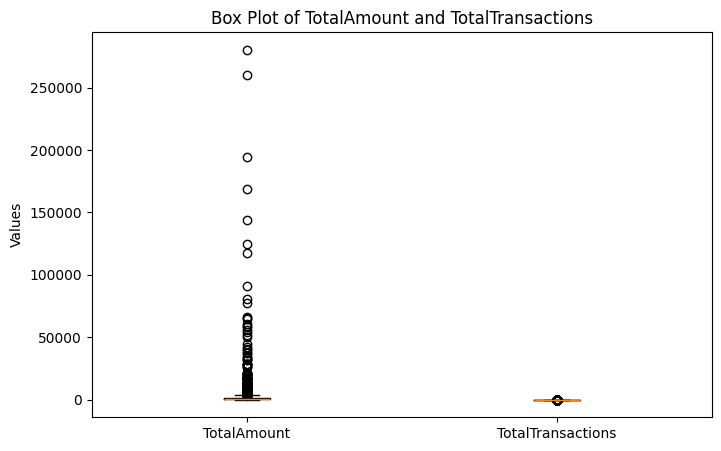

In [11]:
# Step 6: Checking for Outliers
# Drop the CustomerID column from df_segmentation
df_segmentation.drop('CustomerID', axis=1, inplace=True)
# Checking for outliers using box plots
plt.figure(figsize=(8, 5))
plt.boxplot([df_segmentation['TotalAmount'], df_segmentation['TotalTransactions']], labels=['TotalAmount', 'TotalTransactions'])
plt.title('Box Plot of TotalAmount and TotalTransactions')
plt.ylabel('Values')
plt.show()


In [12]:
# Step 7: Removing Outliers from TotalAmount column
# Calculate the IQR for TotalAmount column
Q1 = df_segmentation['TotalAmount'].quantile(0.25)
Q3 = df_segmentation['TotalAmount'].quantile(0.75)
IQR = Q3 - Q1
# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Remove outliers from the TotalAmount column
df_segmentation = df_segmentation[(df_segmentation['TotalAmount'] >= lower_bound) & (df_segmentation['TotalAmount'] <= upper_bound)]
# Display the updated shape of the DataFrame after removing outliers
print("Shape of DataFrame after removing outliers:", df_segmentation.shape)

Shape of DataFrame after removing outliers: (3912, 2)


In [13]:
# Step 8: Data Scaling using Standardization
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()
# Scale the dataset (TotalAmount and TotalTransactions)
df_scaled = scaler.fit_transform(df_segmentation)
# Convert the scaled array back to a DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=df_segmentation.columns)
# Display the first few rows of the scaled DataFrame
print("Scaled DataFrame:")
print(df_scaled.head())

Scaled DataFrame:
   TotalAmount  TotalTransactions
0     1.099421           0.425738
1     1.051512          -0.745491
2    -0.666340          -0.745491
3     1.954997           1.987377
4    -0.962557          -0.745491


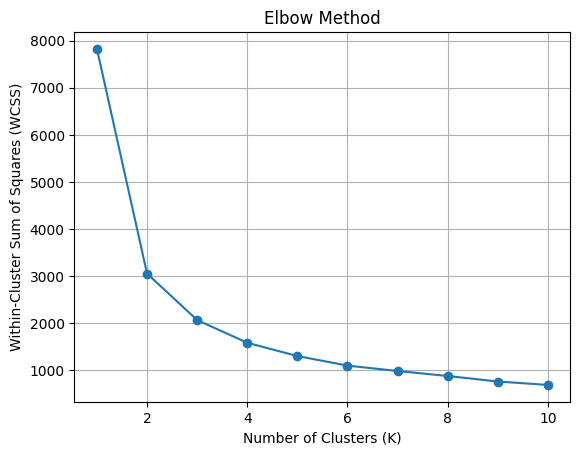

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt  
  
# Create a list to store the WCSS values for different numbers of clusters
wcss = []  
  
# Try different values of K (number of clusters) from 1 to a reasonable maximum
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ contains the WCSS value  
     
# Plot the Elbow Method graph plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.grid(True)
plt.show()


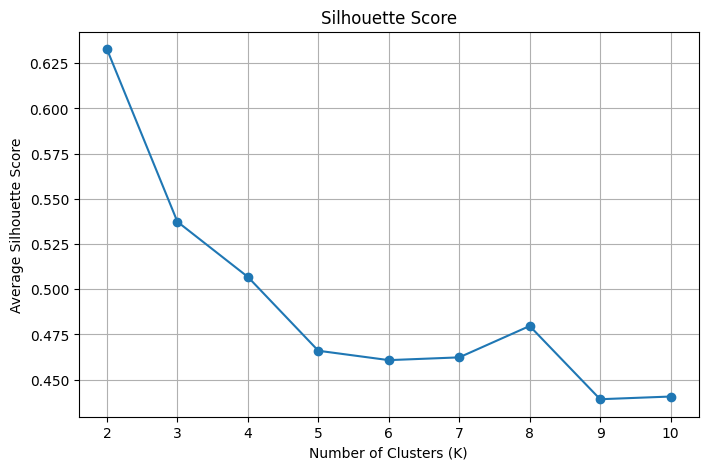

In [17]:
from sklearn.metrics import silhouette_score
# Create a list to store the Silhouette Scores for different numbers of clusters
silhouette_scores = []
# Try different values of K (number of clusters) from 2 to a reasonable maximum
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))
# Plot the Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Score')
plt.grid(True)
plt.show()


In [23]:
from sklearn.cluster import KMeans
# Number of clusters
num_clusters = 6
# Create the KMeans clustering model
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
# Fit the model to the scaled data
kmeans_model.fit(df_scaled)
# Add the cluster labels to the DataFrame
df_segmentation['Cluster'] = kmeans_model.labels_
# Display the first few rows of the DataFrame with cluster assignments
print("Customer Segmentation DataFrame with Cluster Assignments:")
print(df_segmentation.head())

Customer Segmentation DataFrame with Cluster Assignments:
   TotalAmount  TotalTransactions  Cluster
2      1797.24                  4        5
3      1757.55                  1        5
4       334.40                  1        2
5      2506.04                  8        4
6        89.00                  1        2


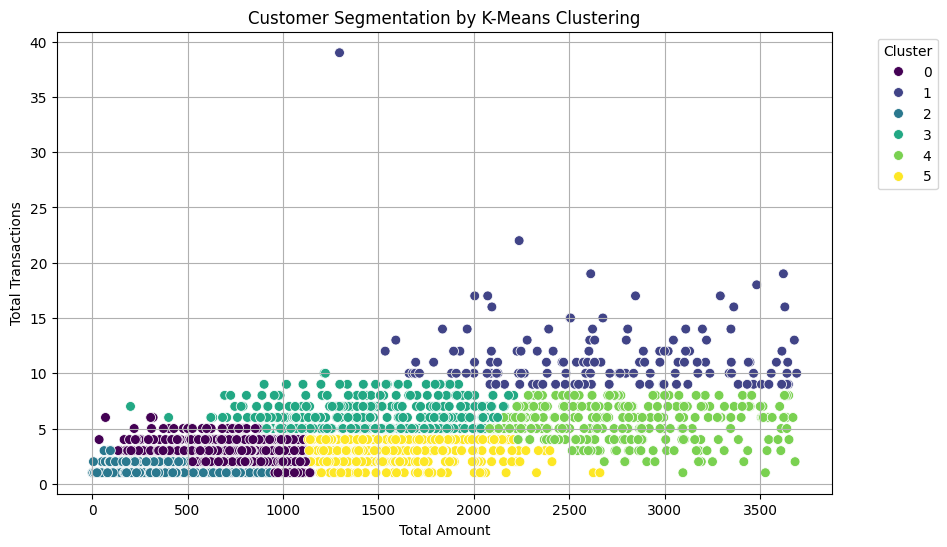

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
# Scatter plot with cluster assignments
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalAmount', y='TotalTransactions', hue='Cluster', data=df_segmentation, palette='viridis', s=50)
plt.xlabel('Total Amount')
plt.ylabel('Total Transactions')
plt.title('Customer Segmentation by K-Means Clustering')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()
